In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

from sklearn.metrics import plot_precision_recall_curve
import scikitplot as skplt
from yellowbrick.classifier import discrimination_threshold

%config IPCompleter.greedy=True
pd.options.display.float_format = '{:.2f}'.format

import warnings
warnings.filterwarnings("ignore")

## UPLOAD DATASETS

In [7]:
path = '../../'

In [8]:
name_x = 'x_selected.pickle'
name_y = 'y_selected.pickle'

In [9]:
x = pd.read_pickle(path + '/02_Data/03_Work/' + name_x)
y = pd.read_pickle(path + '/02_Data/03_Work/' + name_y)

## MODELLING

### Validation Dataset

In [10]:
train_x,val_x,train_y,val_y = train_test_split(x,y,test_size=0.3)

### Pipe y dicts of algorithms, parameters and values to test

In [11]:
pipe = Pipeline([('algorithms',RandomForestClassifier())])

grid = [{'algorithms': [LogisticRegression()],
         'algorithms__n_jobs': [-1],
         'algorithms__solver': ['saga'],
         'algorithms__penalty': ['elasticnet', 'l1', 'l2', 'none'],
         'algorithms__C': [0,0.25,0.5,0.75,1]}
       ]

####  grid search

In [12]:
grid_search = GridSearchCV(estimator= pipe, 
                           param_grid = grid, 
                           cv = 3, 
                           scoring = 'roc_auc',
                           verbose = 0,
                           n_jobs = -1)

model = grid_search.fit(train_x,train_y)

pd.DataFrame(grid_search.cv_results_).sort_values(by = 'rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithms,param_algorithms__C,param_algorithms__n_jobs,param_algorithms__penalty,param_algorithms__solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
19,0.10,0.01,0.01,0.00,"LogisticRegression(C=0, n_jobs=-1, penalty='no...",1,-1,none,saga,"{'algorithms': LogisticRegression(C=0, n_jobs=...",0.87,0.86,0.86,0.86,0.00,1
3,0.14,0.01,0.01,0.00,"LogisticRegression(C=0, n_jobs=-1, penalty='no...",0,-1,none,saga,"{'algorithms': LogisticRegression(C=0, n_jobs=...",0.87,0.86,0.86,0.86,0.00,1
15,0.10,0.00,0.01,0.00,"LogisticRegression(C=0, n_jobs=-1, penalty='no...",0.75,-1,none,saga,"{'algorithms': LogisticRegression(C=0, n_jobs=...",0.87,0.86,0.86,0.86,0.00,3
11,0.12,0.01,0.01,0.00,"LogisticRegression(C=0, n_jobs=-1, penalty='no...",0.50,-1,none,saga,"{'algorithms': LogisticRegression(C=0, n_jobs=...",0.87,0.86,0.86,0.86,0.00,4
7,0.11,0.01,0.01,0.00,"LogisticRegression(C=0, n_jobs=-1, penalty='no...",0.25,-1,none,saga,"{'algorithms': LogisticRegression(C=0, n_jobs=...",0.87,0.86,0.86,0.86,0.00,5


## EVALUATE

In [13]:
pred = model.best_estimator_.predict_proba(val_x)[:, 1]

In [14]:
roc_auc_score(val_y, pred)

0.864017424260111

### Best model

In [15]:
model.best_estimator_

Pipeline(steps=[('algorithms',
                 LogisticRegression(C=0, n_jobs=-1, penalty='none',
                                    solver='saga'))])

In [18]:
model.best_estimator_.named_steps.algorithms.coef_

array([[ 4.25536695,  9.32662409,  1.12648932,  1.21406933,  1.50723917,
        -4.38645766,  2.09515831, -0.75073909, -0.73445515,  0.36293638,
        -1.10992042, -1.65975681, -0.51722416,  0.78111265]])

In [19]:
model.best_estimator_.named_steps.algorithms.feature_names_in_

array(['tiempo_en_site_total_mms', 'score_actividad_mms',
       'ult_actividad_SMS Sent', 'visitas_total_mms', 'score_perfil_mms',
       'paginas_vistas_visita_mms', 'ocupacion_Working Professional',
       'ambito_Select', 'ocupacion_Unemployed', 'descarga_lm_No',
       'ult_actividad_Chat Conversation',
       'ult_actividad_Converted to Lead', 'fuente_Direct Traffic',
       'ult_actividad_OTHER'], dtype=object)

In [22]:
pd.DataFrame(data = model.best_estimator_.named_steps.algorithms.coef_ ,\
            columns=model.best_estimator_.named_steps.algorithms.feature_names_in_).unstack().sort_values(\
                                                                                                         ascending = False)

score_actividad_mms              0    9.33
tiempo_en_site_total_mms         0    4.26
ocupacion_Working Professional   0    2.10
score_perfil_mms                 0    1.51
visitas_total_mms                0    1.21
ult_actividad_SMS Sent           0    1.13
ult_actividad_OTHER              0    0.78
descarga_lm_No                   0    0.36
fuente_Direct Traffic            0   -0.52
ocupacion_Unemployed             0   -0.73
ambito_Select                    0   -0.75
ult_actividad_Chat Conversation  0   -1.11
ult_actividad_Converted to Lead  0   -1.66
paginas_vistas_visita_mms        0   -4.39
dtype: float64

## MODELO REPORTING

### Gain Chart

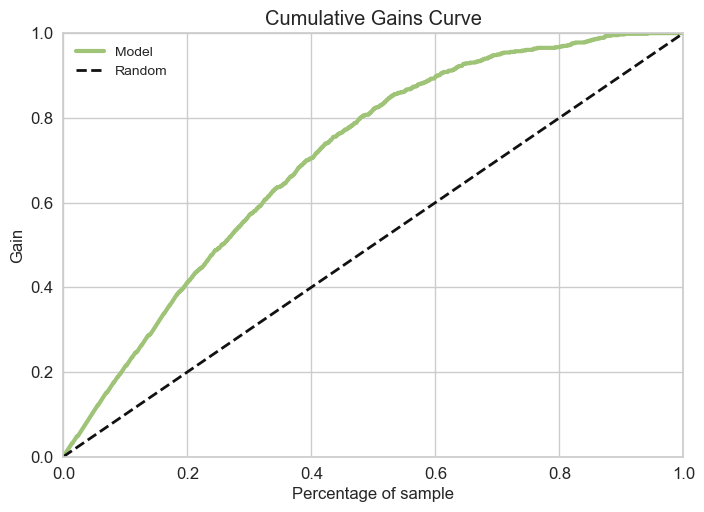

In [25]:
fig, ax = plt.subplots()

skplt.metrics.plot_cumulative_gain(val_y, model.best_estimator_.predict_proba(val_x), ax=ax) 

del ax.lines[0]                 
plt.legend(labels = ['Model','Random']);

### Lift Chart

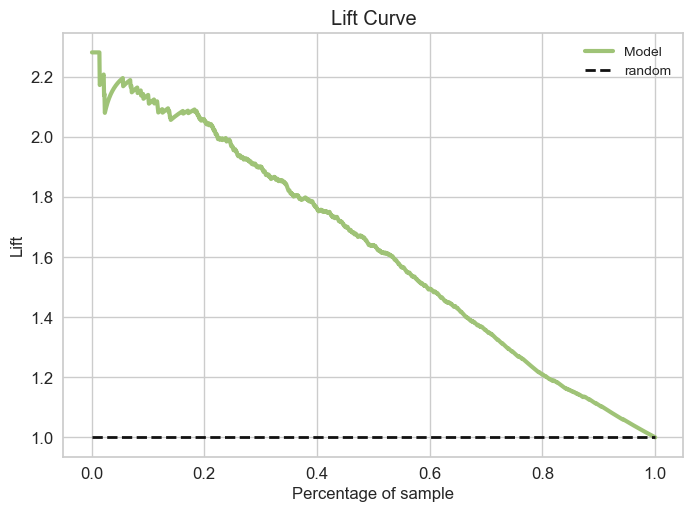

In [26]:
fig, ax = plt.subplots()

skplt.metrics.plot_lift_curve(val_y, model.best_estimator_.predict_proba(val_x), ax=ax) 

del ax.lines[0]                 
plt.legend(labels = ['Model','random']);

### ROC Chart

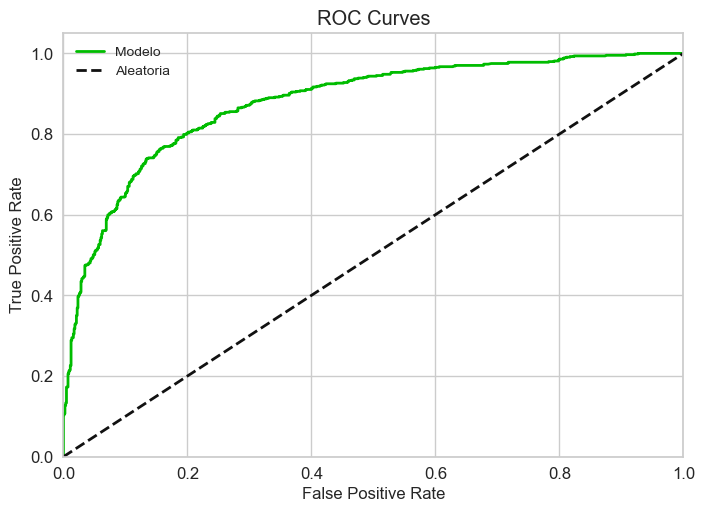

In [17]:
fig, ax = plt.subplots()

skplt.metrics.plot_roc(val_y, modelo.best_estimator_.predict_proba(val_x), ax=ax) 

del ax.lines[0]                 
del ax.lines[1] 
del ax.lines[1]
plt.legend(labels = ['Model','Aleatoria']);